# Face Expression Recognition Kaggle Challenge (FER 2013) with fastai v1

by: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/) (november 2018)

- Inspired by [Recognizing Facial Expressions Using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/224.pdf) (2017) of Alexandru Savoiu and James Wong (Stanford University)
- Database : [FER 2013 Kaggle Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/)
- DL coding with [fastai v1](https://www.fast.ai/2018/10/02/fastai-ai/)
- Plataform used : [crestle.ai](https://www.crestle.ai) (NVIDIA Tesla K80 GPU)

# Motivation

Read post "[Face Expression Recognition with fastai v1]()".

# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Kaggle API setup

1. Create your [Kaggle](https://www.kaggle.com) account.
2. Go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials (user name and password).
2. Install the [Kaggle API](https://github.com/Kaggle/kaggle-api) (run the `pip install kaggle` command in a Terminal and place the kaggle.json file in the location `~/.kaggle/kaggle.json`). 
3. For your security, ensure that other users of your computer do not have read access to your credentials. On Unix-based systems you can do this with the following command: `chmod 600 ~/.kaggle/kaggle.json`

# Data

## Download from Kaggle

In [3]:
# notebook run on www.crestle.ai
%pwd

'/home/nbuser/courses/fast-ai/course-v3/nbs/dl1'

In [ ]:
# Go to your data folder
%cd ../data/

# Download the FER 2013 data from your Kaggle account (all.zip)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [ ]:
# Unzip all.zip in data/FER
!unzip all.zip -d FER

In [ ]:
# Untar fer2013.tar.gz in data/FER
!tar -xvf FER/fer2013.tar.gz -C FER

## Overview

In [5]:
PATH = Path('./FER/fer2013')
PATH.ls()

[PosixPath('FER/fer2013/train'),
 PosixPath('FER/fer2013/README'),
 PosixPath('FER/fer2013/fer2013.bib'),
 PosixPath('FER/fer2013/valid'),
 PosixPath('FER/fer2013/fer2013.csv'),
 PosixPath('FER/fer2013/test'),
 PosixPath('FER/fer2013/models')]

In [6]:
df = pd.read_csv(PATH/'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
# 7 types (emotions) of images from the Data Description of the Kaggle challenge
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [8]:
# 3 usages of the images
usages = df['Usage'].unique();usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [9]:
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


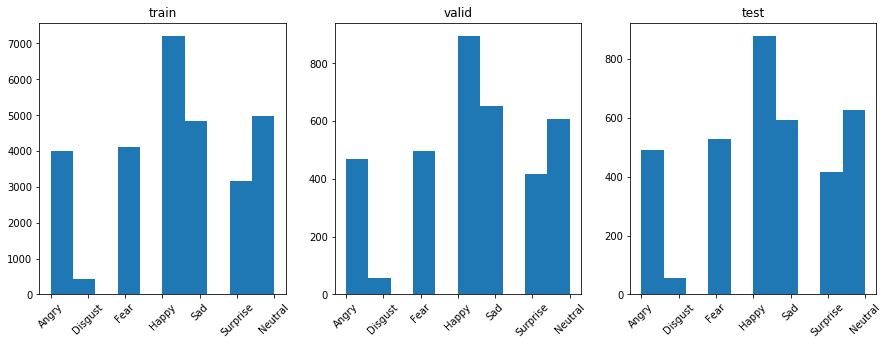

In [10]:
# histograms of train, val and test
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'train')
setup_axe(axes[1],df_valid,'valid')
setup_axe(axes[2],df_test,'test')
plt.show()

In [11]:
# (train) pourcentage of images by emotion
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


In [12]:
# get image + emotion from a dataframe row
# image format : numpy array RGB (48,48,3)
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# display image with title (emotion label)
# image format : numpy array RGB (48,48,3)
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

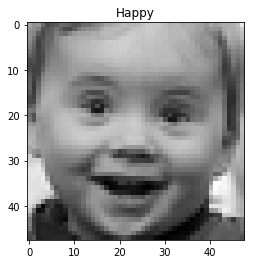

In [13]:
row = df_train.iloc[2222]
img = row2image(row)
show(img)

# Save data (pixels) as images into train/val/test folders

In [15]:
# create the folders train, val and test
Path(PATH/'train').mkdir(exist_ok=True)
Path(PATH/'valid').mkdir(exist_ok=True)
Path(PATH/'test').mkdir(exist_ok=True)

In [14]:
PATH_train = PATH/'train'
PATH_valid = PATH/'valid'
PATH_test = PATH/'test'

In [17]:
# create the folders of the 7 emotions in train, val and test folders
for l in labels:
    Path(PATH_train/l).mkdir(exist_ok=True)
    Path(PATH_valid/l).mkdir(exist_ok=True)
    Path(PATH_test/l).mkdir(exist_ok=True)

In [18]:
# create images from pixels and save them into their corresponding subfolder of train, val and test
def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path/labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = Image.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e/fname)
            i += 1

In [19]:
%%time
createImages(df_train,PATH_train)
createImages(df_valid,PATH_valid)
createImages(df_test,PATH_test)

CPU times: user 1min 58s, sys: 2.02 s, total: 2min
Wall time: 2min


In [15]:
p = PATH_train/'Angry'
p.ls()[:5]

[PosixPath('FER/fer2013/train/Angry/0_1309.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2177.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2748.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2698.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_3780.jpg')]

# Get Dataset and Dataloader (ImageDataBunch in fastai v1)

In [16]:
# data augmentation
tfms = get_transforms()

In [17]:
# ImageDataBunch
# bs=32, size=299 : ajusted hyper-parameters to resnet50
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=32, size=299)
data.normalize(imagenet_stats)

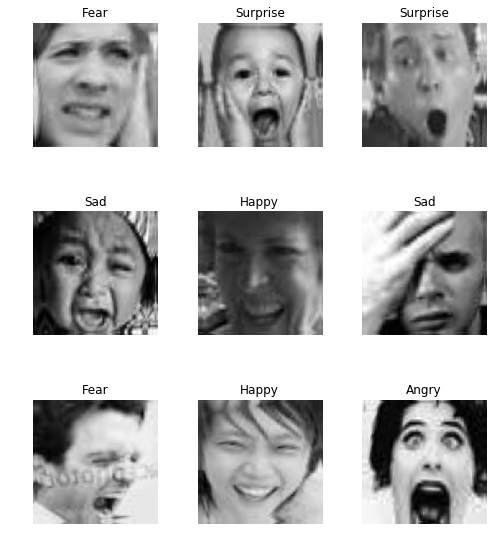

In [18]:
data.show_batch(rows=3, figsize=(7,8))

In [19]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

# Train model (resnet50)

In [20]:
learn = create_cnn(data, models.resnet50, metrics=[accuracy])

In [19]:
learn.fit_one_cycle(4)

Total time: 58:13
epoch  train_loss  valid_loss  accuracy
1      1.362602    1.270015    0.512678  (14:52)
2      1.206377    1.128104    0.570075  (14:27)
3      1.105552    1.038691    0.606297  (14:26)
4      1.029919    1.014301    0.611034  (14:26)



In [20]:
learn.save('fer2013-stage-1')

In [23]:
learn.load('fer2013-stage-1')

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


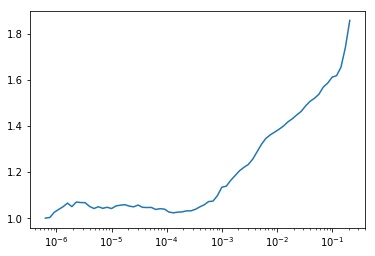

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 38:40
epoch  train_loss  valid_loss  accuracy
1      0.987011    1.001112    0.619950  (19:22)
2      0.973817    0.988086    0.625522  (19:18)



In [20]:
learn.save('fer2013-stage-2')

In [28]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 38:37
epoch  train_loss  valid_loss  accuracy
1      0.928335    0.978616    0.632767  (19:18)
2      0.907880    0.957925    0.641683  (19:18)



In [29]:
learn.save('fer2013-stage-3')

In [30]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 38:37
epoch  train_loss  valid_loss  accuracy
1      0.923969    0.948924    0.644469  (19:19)
2      0.856066    0.942122    0.649485  (19:18)



In [31]:
learn.save('fer2013-stage-4')

In [22]:
learn.load('fer2013-stage-4')

In [23]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 29:17
epoch  train_loss  valid_loss  accuracy
1      0.838814    0.943295    0.649763  (14:51)
2      0.850060    0.946577    0.651714  (14:26)



In [24]:
learn.save('fer2013-stage-5')

# Results

In [21]:
learn.load('fer2013-stage-5')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

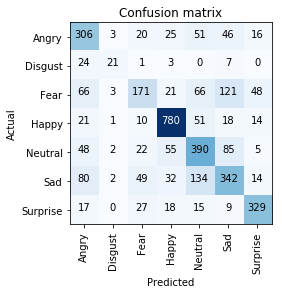

In [23]:
interp.plot_confusion_matrix()

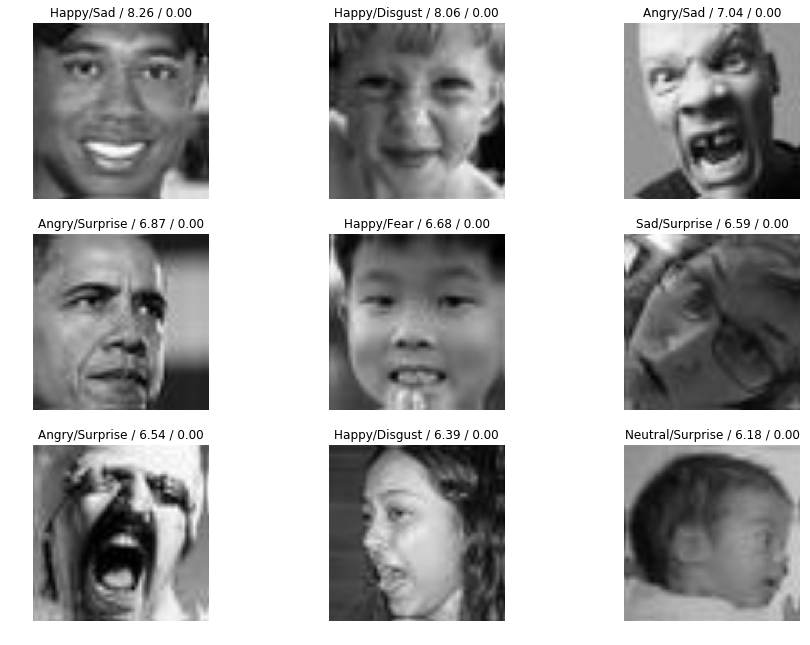

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

# Accuracy

In [25]:
learn.load('fer2013-stage-5')

In [26]:
val_probs, val_targets = learn.get_preds()

In [27]:
val_preds = torch.argmax(val_probs,1)

In [28]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

valid accuracy: 65.17%


# Putting the model in production

In [38]:
data.classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

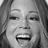

In [41]:
# get image from test folder (images arquived in subfolders)
p = PATH_test/'Happy'
url = p.ls()[1]
img = open_image(url)
img

In [42]:
# get prediction
probs = img.predict(learn)
prediction = learn.data.classes[probs.argmax()]
prediction

'Happy'